## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists 

For this project, we will be working to understand the results of an A/B test run by an e-commerce website.  our goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [2]:
ab_df = pd.read_csv('ab_data.csv')
ab_df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# total number of datapoints
ab_df.shape[0]

294478

In [4]:
# number of unique users in the dataset
ab_df.user_id.nunique()

290584

In [5]:
# proportion of users converted
ab_df.converted.mean()

0.11965919355605512

In [6]:
#The number of times the new_page and treatment don't line up
mismatch1 = (ab_df['landing_page'] == "new_page")&(ab_df['group'] == "control")
mismatch2 = (ab_df['landing_page'] == "old_page")&(ab_df['group'] == "treatment")
print(ab_df[mismatch1].shape[0]+ab_df[mismatch2].shape[0])

3893


In [7]:
# as we can see from above, some old pages were given to treatment group
# and some new pages are given to control group, which was wrong
# so lets drop all these 3893 rows, which are wrongly aligned

index_remove = list(ab_df[mismatch1].index) + list(ab_df[mismatch2].index)
ab_df2 = ab_df.drop(labels=index_remove,axis=0)

In [8]:
# Double Check all of the correct rows were removed - this should be 0
ab_df2[((ab_df2['group'] == 'treatment') == (ab_df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [9]:
# checking whether the data has any null values
ab_df2.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [10]:
# total unique ids of the new dataframe
ab_df2.user_id.nunique()

290584

In [11]:
# non unique userid
ab_df2.loc[ab_df2.user_id.duplicated(),:]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
#droping the non unique id 
ab_df2 = ab_df2.drop(labels=2893)



a. probability of an individual converting regardless of the page they receive?

In [13]:
# probability of conversion regardless of page
ab_df2.converted.mean()

0.11959708724499628

In [14]:
# control group converting mean
ab_df2.query('group == "control"')['converted'].mean()

0.1203863045004612

In [15]:
# treatment group converting mean
ab_df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [16]:
# probability of recieving new page
# probability of recieving old page
new_page_p = ab_df2.landing_page.value_counts()[0]/ab_df2.shape[0]
old_page_p = ab_df2.landing_page.value_counts()[1]/ab_df2.shape[0]
print(('new page probability', new_page_p),('old page probability', old_page_p))

('new page probability', 0.5000619442226688) ('old page probability', 0.4999380557773312)


# observation
**as we can see from above, both the old page, and new page has almost equal probability(0.5), but the conversion mean of old page(control group) is 0.120, whereas conversion mean of new page(treatment group) is 0.1188
eventhough there is a very small percentage difference of conversion mean, but i don't think thats practically significant,
I don't think that's a huge conversion difference(0.002), they are almost same. by only considering this 0.002 difference we can't say new page is bringing more conversions than old page**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, our null and alternative hypotheses is 

$$ H_0: p_{new} \leq p_{old}$$
$$ H_1: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

we use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. **convert rate** for $p_{new}$ under the null? 

In [17]:
# convert rate for Pnew under the null
P_new = ab_df2['converted'].mean()
print(P_new)

0.11959708724499628


b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
# what is conversion rate for Pold under the null
P_old = ab_df2['converted'].mean()
print(P_old)

0.11959708724499628


In [19]:
P_new - P_old #under null hypothesis

0.0

c. What is $n_{new}$?

In [20]:
n_new = ab_df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [21]:
n_old = ab_df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# n_new transcations conversion sample values
new_page_converted = np.random.binomial(1,P_new,n_new)
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# n_old transactions conversion sample
old_page_converted = np.random.binomial(1, P_old, n_old)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
# checking whether we drew the currect number of samples
print(len(new_page_converted) == n_new, len(old_page_converted) == n_old)

True True


g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
dif = new_page_converted.mean() - old_page_converted.mean()
dif

0.00014256179585862838

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    new_page_converted1 = np.random.binomial(1,P_new,n_new)
    old_page_converted1 = np.random.binomial(1, P_old, n_old)
    p_diffs.append(new_page_converted1.mean()-old_page_converted1.mean())

In [27]:
p_diffs = np.asarray(p_diffs) # converting p_diffs to numpy array

i. Plotting a histogram of the **p_diffs**

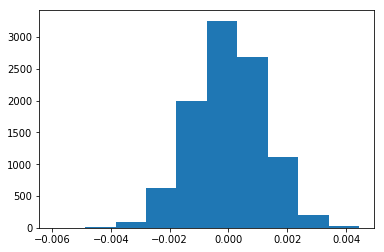

In [28]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [29]:
actual_diff = (ab_df2.query('group == "treatment"')['converted'].mean() - ab_df2.query('group == "control"')['converted'].mean())
(p_diffs > actual_diff).mean()

0.9045

In [30]:
actual_diff

-0.0015782389853555567

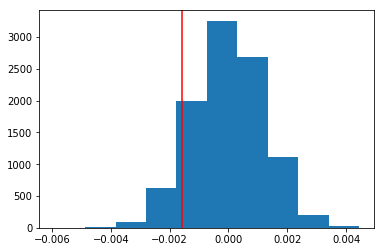

In [31]:
plt.hist(p_diffs)
plt.axvline(actual_diff, c='r');

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**we calculated the pvalue(0.9034) and we got it arround 90%, this suugests that the probability of getting the actual difference(-0.0015) from the null hypothesis is 90%, considering the alpha value of 5, the pvalue is too high, and we clearly fail to reject null hypothesis considering the pvalue.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [32]:
import statsmodels.api as sm

convert_old = ab_df2.query('group == "control"')['converted'].sum()
convert_new = ab_df2.query('group == "treatment"')['converted'].sum()
n_old = ab_df2.query('group == "control"').shape[0]
n_new = ab_df2.query('group == "treatment"').shape[0]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [33]:
print(convert_new, convert_old, n_new, n_old)

17264 17489 145310 145274


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new], alternative='smaller')

In [35]:
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


In [36]:
from scipy.stats import norm
print(norm.cdf(z_score)) # Tells us how significant our z-score is

print(norm.ppf(1-(0.05))) # Tells us what our critical value at 95% confidence is

0.9050583127590245
1.6448536269514722


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<b>since the z score of 1.31 is less than critical value of 1.64 as seen above, we failed to reject the null hypothesis which suggests that old page conversion probablity is equal or better than the new page conversions
and also we got almost same pvalue of 0.90 as we got in part j and k, so the previous observations still remains same, and we have no evidence to reject null hypothesis</b>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Considering the categorical response, either conversion or no conversion, logistic regression will be the best fit in this case**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [37]:
ab_df2['intercept'] = 1
ab_df2['ab_page'] = pd.get_dummies(ab_df2.landing_page)['new_page']
ab_df2.head() 

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [38]:
#import statsmodels.api as sm
logmod = sm.Logit(ab_df2['converted'], ab_df2[['intercept','ab_page']])
results = logmod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2() # since in my system results.summary() is giving an error i have used results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-06-23 21:19 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [40]:
np.exp(-0.0150)  #ab_page coefficient = -0.0150

0.9851119396030626

### the above result suggests that ab_page is 0..98 times likely converseble, again not much difference

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**for the logistic regression the null and alternative hyposthesis is 
$$ H_0: p_{new} = p_{old}$$
$$ H_1: p_{new} \neq p_{old}$$
so logistic regression is two sided test, whereas part 2 is one sided test having null and alternative as 
$$ H_0: p_{new} \leq p_{old}$$
$$ H_1: p_{new} > p_{old}$$,
the pvalue for the regression model is 0.189, which is higher than the 0.05 significance level, which means the new page conversion is not statastically significant**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**.yeah, definitely having other factors that influence the converts will increase the r squared valued of our model, for example details about the page, like the old page has only images, while the new page contains video demonstration about the companies product, so adding about the type of content of the page may increase the r squared, but we should be careful while adding factors, we should make sure that newly added factors should not have much colinear with the existing factors, because multicolinearity may increase the variance of the coefficient estimates  **

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
countries_df = pd.read_csv('countries.csv')
ab_df_new = countries_df.set_index('user_id').join(ab_df2.set_index('user_id'), how='inner')

In [42]:
ab_df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [43]:
### Create the necessary dummy variables
ab_df_new[['CA','UK','US']] = pd.get_dummies(ab_df_new.country)

In [44]:
ab_df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [45]:
lm2 = sm.Logit(ab_df_new['converted'], ab_df_new[['intercept','CA','UK']])
result2 = lm2.fit()
result2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-06-23 21:19 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0408    0.0269    -1.5178  0.1291  -0.0935   0.0119
UK            0.0099    0.0133     0.7458  0.4558  -0.0161   0.0360
==================================================================

"""

In [46]:
# the above p values 0.1291 and 0.4558 clearly states no significance
print(1/np.exp(-0.0408),1/np.exp(0.0099))

1.0416437559600236 0.9901488436829571


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
# interactions between treatment page and country
ab_df_new['treatment_US'] = ab_df_new.ab_page * ab_df_new.US
ab_df_new['treatment_CA'] = ab_df_new.ab_page * ab_df_new.CA
ab_df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,treatment_US,treatment_CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,0


In [48]:
### Fit Your Linear Model And Obtain the Results
lm3 = sm.Logit(ab_df_new['converted'], ab_df_new[['intercept','CA','UK','treatment_US','treatment_CA']])
result3 = lm3.fit()
result3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2018-06-23 21:19 AIC:              212780.8857
No. Observations:   290584           BIC:              212833.7840
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
------------------------------------------------------------------
                  Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
intercept        -1.9865   0.0096 -206.3440 0.0000 -2.0053 -1.9676
CA               -0.0175   0.0377   -0.4652 0.6418 -0.0914  0.0563
UK               -0.0003   0.0149   -0.0224 0.9821 -0.0296  0.0289
treatment_US     -0.0206   0.0137   -1.5052 0.1323 -0.0473  0.0062
treatment_CA     -0.0674   0.0520   -1.2967 0.1947 -0.1694  0.0345
==================================================================

"""

based on the above p values, we can say that the interaction between treatment page and countries also not less than the significance level 0.05, resulting no significance, and failing to reject null hypothesis

<a id='conclusions'></a>
## Conclusions
<b>Based on the A/B tests and regression models, we have no evedince to reject the null hypothesis, so the company shouldn't implement the new page</b>